# Feature Engineering

## Importing the dataset

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("data.csv") 

## Feature Selection:

In [2]:
print(df.columns)

Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Weatherconditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken(min)',
       'Pickup_Delay', 'Distance_km', 'Road_traffic_density_encoded'],
      dtype='object')


In [3]:
print(df.head())

       ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0  0x4607     INDORES13DEL02                 37.0                      4.9   
1  0xb379     BANGRES18DEL02                 34.0                      4.5   
2  0x5d6d     BANGRES19DEL01                 23.0                      4.4   
3  0x7a6a    COIMBRES13DEL02                 38.0                      4.7   
4  0x70a2     CHENRES12DEL01                 32.0                      4.6   

   Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0            22.745049             75.892471                   22.765049   
1            12.913041             77.683237                   13.043041   
2            12.914264             77.678400                   12.924264   
3            11.003669             76.976494                   11.053669   
4            12.972793             80.249982                   13.012793   

   Delivery_location_longitude  Order_Date          Time_Orderd  ...  \
0 

In [4]:
# Convert "Unknown" back to NaN (optional)
df.replace("Unknown", np.nan, inplace=True)

# Drop rows with NaNs
df.dropna(inplace=True)


In [5]:
selected_features = [
    "Distance_km",
    "Road_traffic_density_encoded",
    "Delivery_person_Age",
    "multiple_deliveries",
    "Festival"    
]

target_variable = "Time_taken(min)"


# Model Training & Evaluation

In [6]:
from sklearn.model_selection import train_test_split

X = df[selected_features]
y = df[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)


# Model Selection

# Linear Regression (Baseline Model)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

Linear Regression MAE: 5.736525887257455
Linear Regression RMSE: 7.1604475233122855


# Random Forest Regression

In [8]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest MAE:", mean_absolute_error(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random Forest MAE: 5.916610628798589
Random Forest RMSE: 7.54562345224295


## Gradient Boosting (XGBoost)

In [9]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print("XGBoost MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

XGBoost MAE: 5.330085277557373
XGBoost RMSE: 6.7458921577978606


## Model Training & Evaluation

In [10]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Initialize the XGBoost regressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Example param grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2
)

In [11]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)


In [12]:
# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_


Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [13]:

# Train the model with best params
best_model = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Tuned XGBoost MAE: {mae:.2f}")
print(f"Tuned XGBoost RMSE: {rmse:.2f}")


Tuned XGBoost MAE: 5.22
Tuned XGBoost RMSE: 6.61


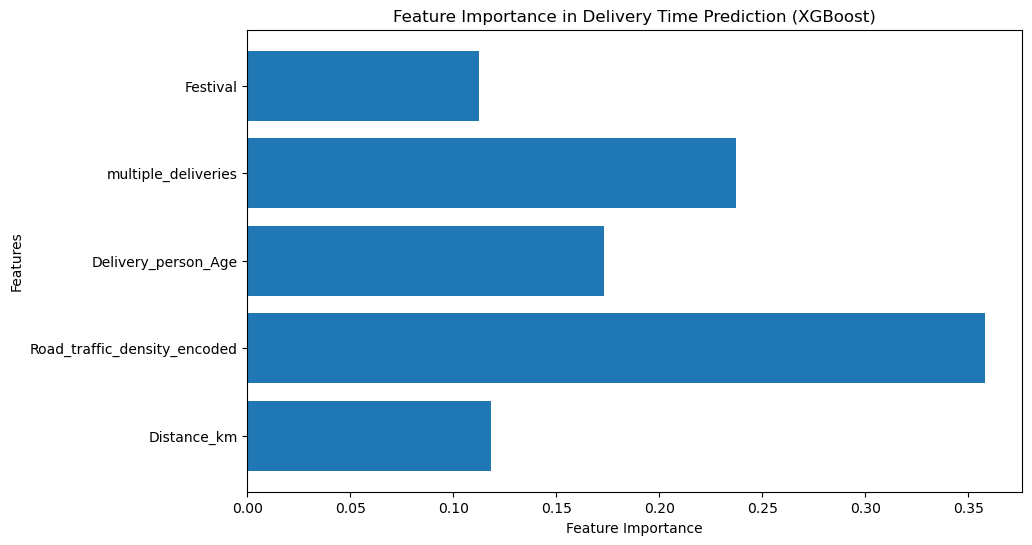

In [14]:
import matplotlib.pyplot as plt

# Plot feature importance
importance = best_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importance)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Delivery Time Prediction (XGBoost)")
plt.show()


In [15]:
# Combine features and their importance into a DataFrame
feature_importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importance
})


# Sort the table by importance
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).reset_index(drop=True)

# Print the table
print(feature_importance_df)


                        Feature  Importance
0  Road_traffic_density_encoded    0.358298
1           multiple_deliveries    0.237240
2           Delivery_person_Age    0.173336
3                   Distance_km    0.118476
4                      Festival    0.112651
